# !!! Change the Filename accordingly !!!

In [1]:
figure_name = 'figures/fig_3_parameter_cp_'

In [18]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from scipy.ndimage.filters import convolve1d

import dill

from mpl_toolkits.mplot3d import Axes3D
from skimage import measure
plt.style.use('seaborn-whitegrid')

mpl.rcParams['grid.linestyle'] = ':'   

drawing_size = 12


mpl.rcParams['font.size'] = drawing_size
mpl.rcParams['font.style'] = 'normal'
mpl.rcParams['font.weight']= 'normal'
mpl.rcParams['font.family'] =  ['Arial']



mpl.rcParams['figure.titlesize'] = int(drawing_size*1.0)
mpl.rcParams['figure.titleweight'] = 'heavy'

mpl.rcParams['lines.linewidth'] = int(drawing_size/5)

mpl.rcParams['axes.labelsize'] = drawing_size
mpl.rcParams['axes.labelweight'] = 'heavy'
mpl.rcParams['axes.titlesize'] = int(drawing_size*1.0)
mpl.rcParams['axes.titleweight'] = 'heavy'


mpl.rcParams['legend.fancybox'] = True
mpl.rcParams['legend.fontsize'] = int(drawing_size*0.9)
mpl.rcParams['legend.frameon'] = True
mpl.rcParams['legend.framealpha'] = 0.5
mpl.rcParams['legend.facecolor'] = 'inherit'
mpl.rcParams['legend.edgecolor'] = '0.8'


mpl.rcParams['figure.figsize'] = [8.0, 5.0]
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['savefig.dpi'] = 300

# print(mpl.rcParams.keys())


In [6]:


   
############################################################
#                  Simulation parameter                    #
############################################################

# Define initial condition (not necessary?)
#x0 = 0

# Time step
dt = 0.001 # -> 10us

# Solve differential equation from time 0 to time T
T = 8.0 # -> 80ms 

# Descretize time into equal steps
t = np . linspace (0 , T , int ( T / dt )+1)


############################################################
#                Network Inputs/Outputs                    #
############################################################

# define the inputs
# assuming we have 16 frquency bands
freq_bands = 5

############################################################
#                 BPC neuron parameter                     #
#  parameters for r_bpc neuron of LSO, all marked by a _r  #
############################################################
# tau defines how fast the membrane potential builds up
tau_r = 1/40.0
# alpha defines the decay rate of the membrane potential but also the value to which it saturates (implicitly)
alpha_r = 1.0
# beta defines the upper limit of the membrane potential
beta_r = 1.0
# gamma defines the subtractive influence of the inhibitory input
gamma_r = 3.0
# kappa defines the divisive influence of the inhibitory input
kappa_r = 4.0

############################################################
#                 PC neuron parameter                      #
#  parameters for q_pc neuron of MNTB, all marked by a _q  #
############################################################
tau_q = 1/40.0
alpha_q = 2.0 
beta_q = 1.0
gamma_q = 0.0
kappa_q = 0.0

In [7]:
############################################################
#                       Functions                          #
############################################################




#define a gauss function
def gauss(x,mean,sigma):
    if sigma == 0.0:
        return np.zeros(x.shape)
    else: 
        return np.exp(-(x-mean)**2 /( 2 * sigma**2 ))


# Defines the output transfer function of r_bpc
def g_r_out(r_bpc,a =20,b=0.20):
    return 1 / (1 + np.exp(-(r_bpc-b)*a) )

# Defines the output transfer function of q_pc
def g_q_out(q_pc):
    return np.minimum(np.maximum(q_pc,0),1)



# Defines the ODE for the r_bpc neuron
def ode_r_bpc(r_bpc,s_sbc,ee_kernel,q_pc,ei_kernel,gaba_exc=0,gaba_inh=0):
    # get the globally defined parameters
    global tau_r ,alpha_r, beta_r, gamma_r, kappa_r

    # default gaba inhibiton
#     gaba_inh -= 0.01
    # calculate excitatory input, which comes from the SBC cells folded by the E-E kernel
    excitatory_in = convolve1d(s_sbc,weights=ee_kernel,axis=0,mode='reflect')*(1-gaba_exc)
    # calculate inhibitor input, which comes from the q_pc folded by the E-I kernel
    inhibitory_in = convolve1d(g_q_out(q_pc),weights=ei_kernel,axis=0,mode='reflect')*(1-gaba_inh)     
    # calculate the change of r_bpc
    d_r_bpc = -alpha_r * r_bpc + (beta_r-r_bpc) * excitatory_in - ((gamma_r) + kappa_r * r_bpc) * inhibitory_in
    
        
    return d_r_bpc / tau_r


# Defines the ODE for the q_pc neuron
def ode_q_pc(q_pc, s_gbc,ie_kernel,q_pc_all,ii_kernel):
    # get the globally defined parameters
    global tau_q,alpha_q,beta_q,gamma_q,kappa_q

    # calculate excitatory input, which comes from the GBC cells folded by the I-E kernel
    excitatory_in = convolve1d(s_gbc,weights=ie_kernel,axis=0,mode='reflect')
    # calculate inhibitor input, which comes from the q_pc folded by the I-I kernel (self-inhibition)
    inhibitory_in = convolve1d(g_q_out(q_pc_all),weights=ii_kernel,axis=0,mode='reflect')     
    
    d_q_pc = -alpha_q * q_pc + beta_q * excitatory_in - (gamma_q + kappa_q * q_pc) * inhibitory_in 
    
    return d_q_pc /tau_q

## Feasible Range

In [8]:


############################################################
#                       Inputs                             #
############################################################
s_gbc_all= np.zeros((len(t),freq_bands))
s_sbc_all = np.zeros((len(t),freq_bands))


kappas_r = np.linspace(0,10,40)
gammas_r = np.linspace(0,10,40)


all_para_r = [ (i,j) for i in kappas_r for j in gammas_r]



############################################################
#                       Inputs                             #
############################################################
s_gbc_all= np.zeros((len(t),freq_bands))
s_sbc_all = np.zeros((len(t),freq_bands))

# Define input signal in a plausible way (gaussian input signal over frequency bands?)
# Define input signal in a plausible way (gaussian input signal over frequency bands?)
sigma = 1.0

### MNTB inhibitory input (contra-lateral) ###
gbc_center_frequencyBand =2
gbc_input_strength = 1.0

# build ramps
time_window = 400 # that equals a step of 5dB
for i in range(0,len(t)-time_window,time_window):
    s_gbc_all[i:i+time_window,:] = (i)/(len(t)-time_window) * gbc_input_strength



# LSO direct excitatory input (ipsi-lateral)
sbc_center_frequencyBand = 2
sbc_input_strength = 1.0

# build ramps
for i in range(0,len(t)-time_window,time_window):
    s_sbc_all[i:i+time_window,:] = (len(t)-time_window-i)/(len(t)-time_window) * sbc_input_strength

    

gauss_mask = gauss(np.linspace(-50,50,5000),0,1)
s_gbc_all = convolve1d(s_gbc_all,weights=gauss_mask/gauss_mask.sum(),axis=0,mode='reflect')
gauss_mask = gauss(np.linspace(-50,50,5000),0,1)
s_sbc_all = convolve1d(s_sbc_all,weights=gauss_mask/gauss_mask.sum(),axis=0,mode='reflect')




# correct for border effect of convolve
s_gbc_all[-250:,:] = np.max(s_gbc_all[-250:])
s_sbc_all[:250,:] = np.max(s_sbc_all[:250])

sigma =0.5
ee_kernel = gauss(np.arange(-10*sigma,+10*sigma),0,sigma)
sigma = 0.6
ei_kernel = gauss(np.arange(-10*sigma,+10*sigma),0,sigma)
sigma = 0.1
ie_kernel = gauss(np.arange(-10*sigma,+10*sigma),0,sigma)
sigma = 1.0
ii_kernel = gauss(np.arange(-10*sigma,+10*sigma),0,sigma)

ee_kernel /= np.max(ee_kernel)
ei_kernel /= np.max(ie_kernel)
ie_kernel /= np.max(ie_kernel)
ii_kernel /= np.max(ie_kernel)
ii_kernel = np.zeros(freq_bands)


q_all = np.zeros((len(all_para_r),len(t),freq_bands))
r_all = np.zeros((len(all_para_r),len(t),freq_bands))
############################################################
#                      Simulation                          #
############################################################
for k in range(len(all_para_r)):
    kappa_r = all_para_r[k][0]
    gamma_r = all_para_r[k][1]
    for i in range(0, len(t)-1):

        r_all[k,i+1,:] = r_all[k,i,:] +  dt * ode_r_bpc(r_all[k,i,:],s_sbc_all[i],ee_kernel,q_all[k,i,:],ei_kernel)       

        q_all[k,i+1,:] = q_all[k,i,:] +  dt * ode_q_pc(q_all[k,i,:],s_gbc_all[i],ie_kernel,q_all[k,i,:],ii_kernel)












In [23]:
import dill
# dill.dump_session('figure_3_parameters_test')
dill.load_session('figure_3_parameters_test')

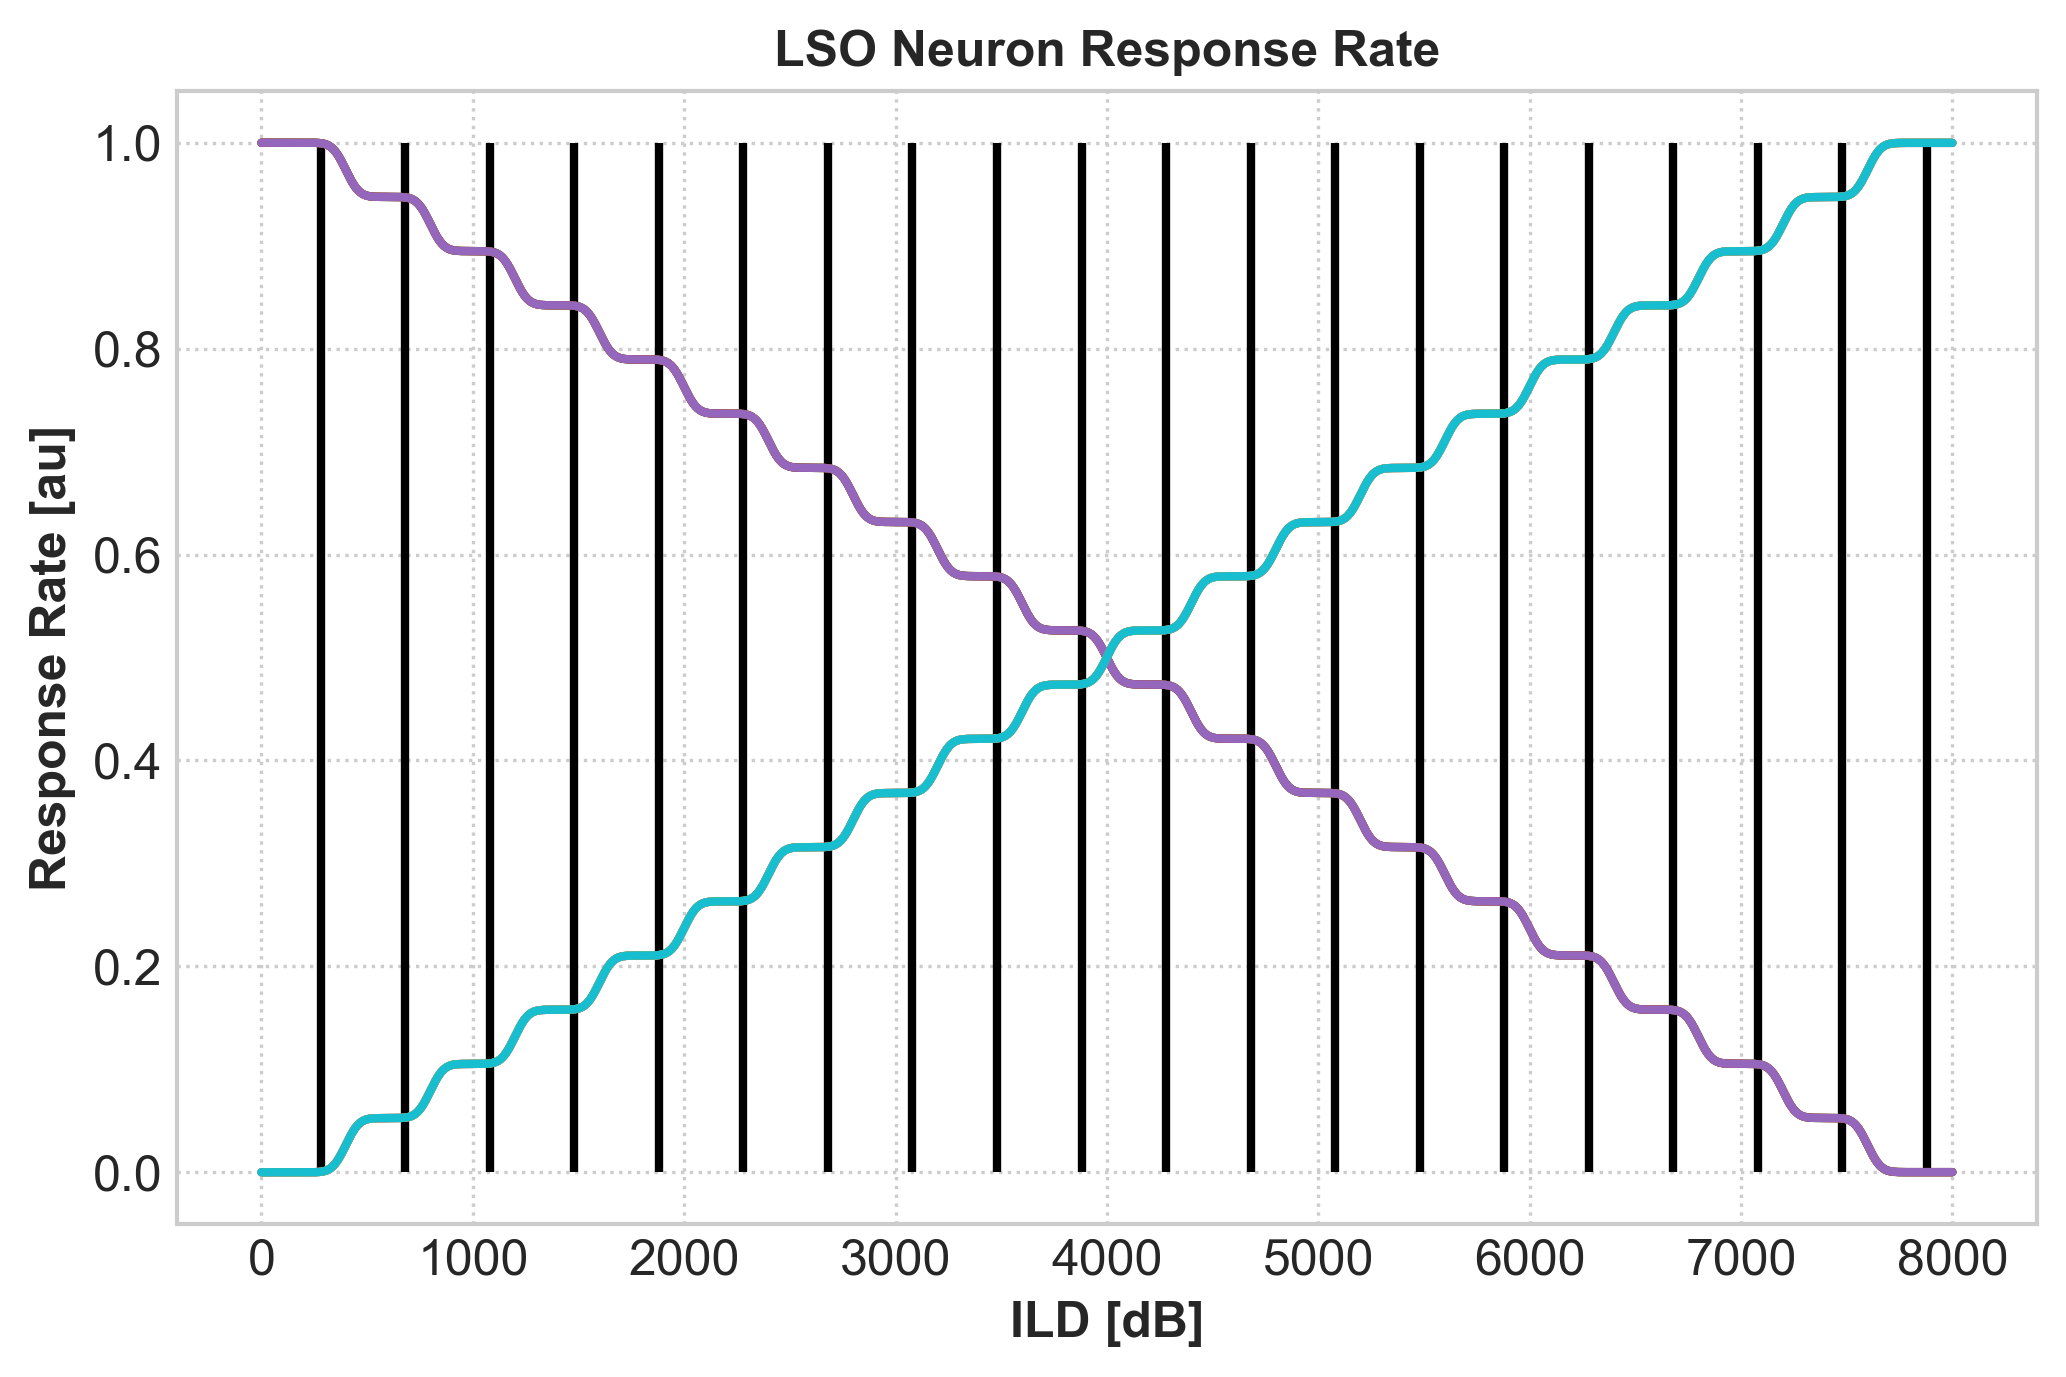

In [19]:
fig = plt.figure()
probing_times = np.arange(280,len(t),time_window)

ax1 = fig.add_subplot(111)
plt.title('LSO Neuron Response Rate')
diff_input =  s_gbc_all-s_sbc_all
diff_input = diff_input[:,sbc_center_frequencyBand]
k = 0

plt.plot(s_sbc_all)
plt.plot(s_gbc_all)

plt.xlabel('ILD [dB]')
plt.ylabel('Response Rate [au]')

plt.vlines(x=probing_times,ymin=0,ymax=1)

# lgd = plt.legend(loc=(1.04,0))


# plt.savefig(figure_name + 'response_all.svg', bbox_extra_artists=(lgd,), bbox_inches='tight')
# plt.savefig(figure_name + 'response_all.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

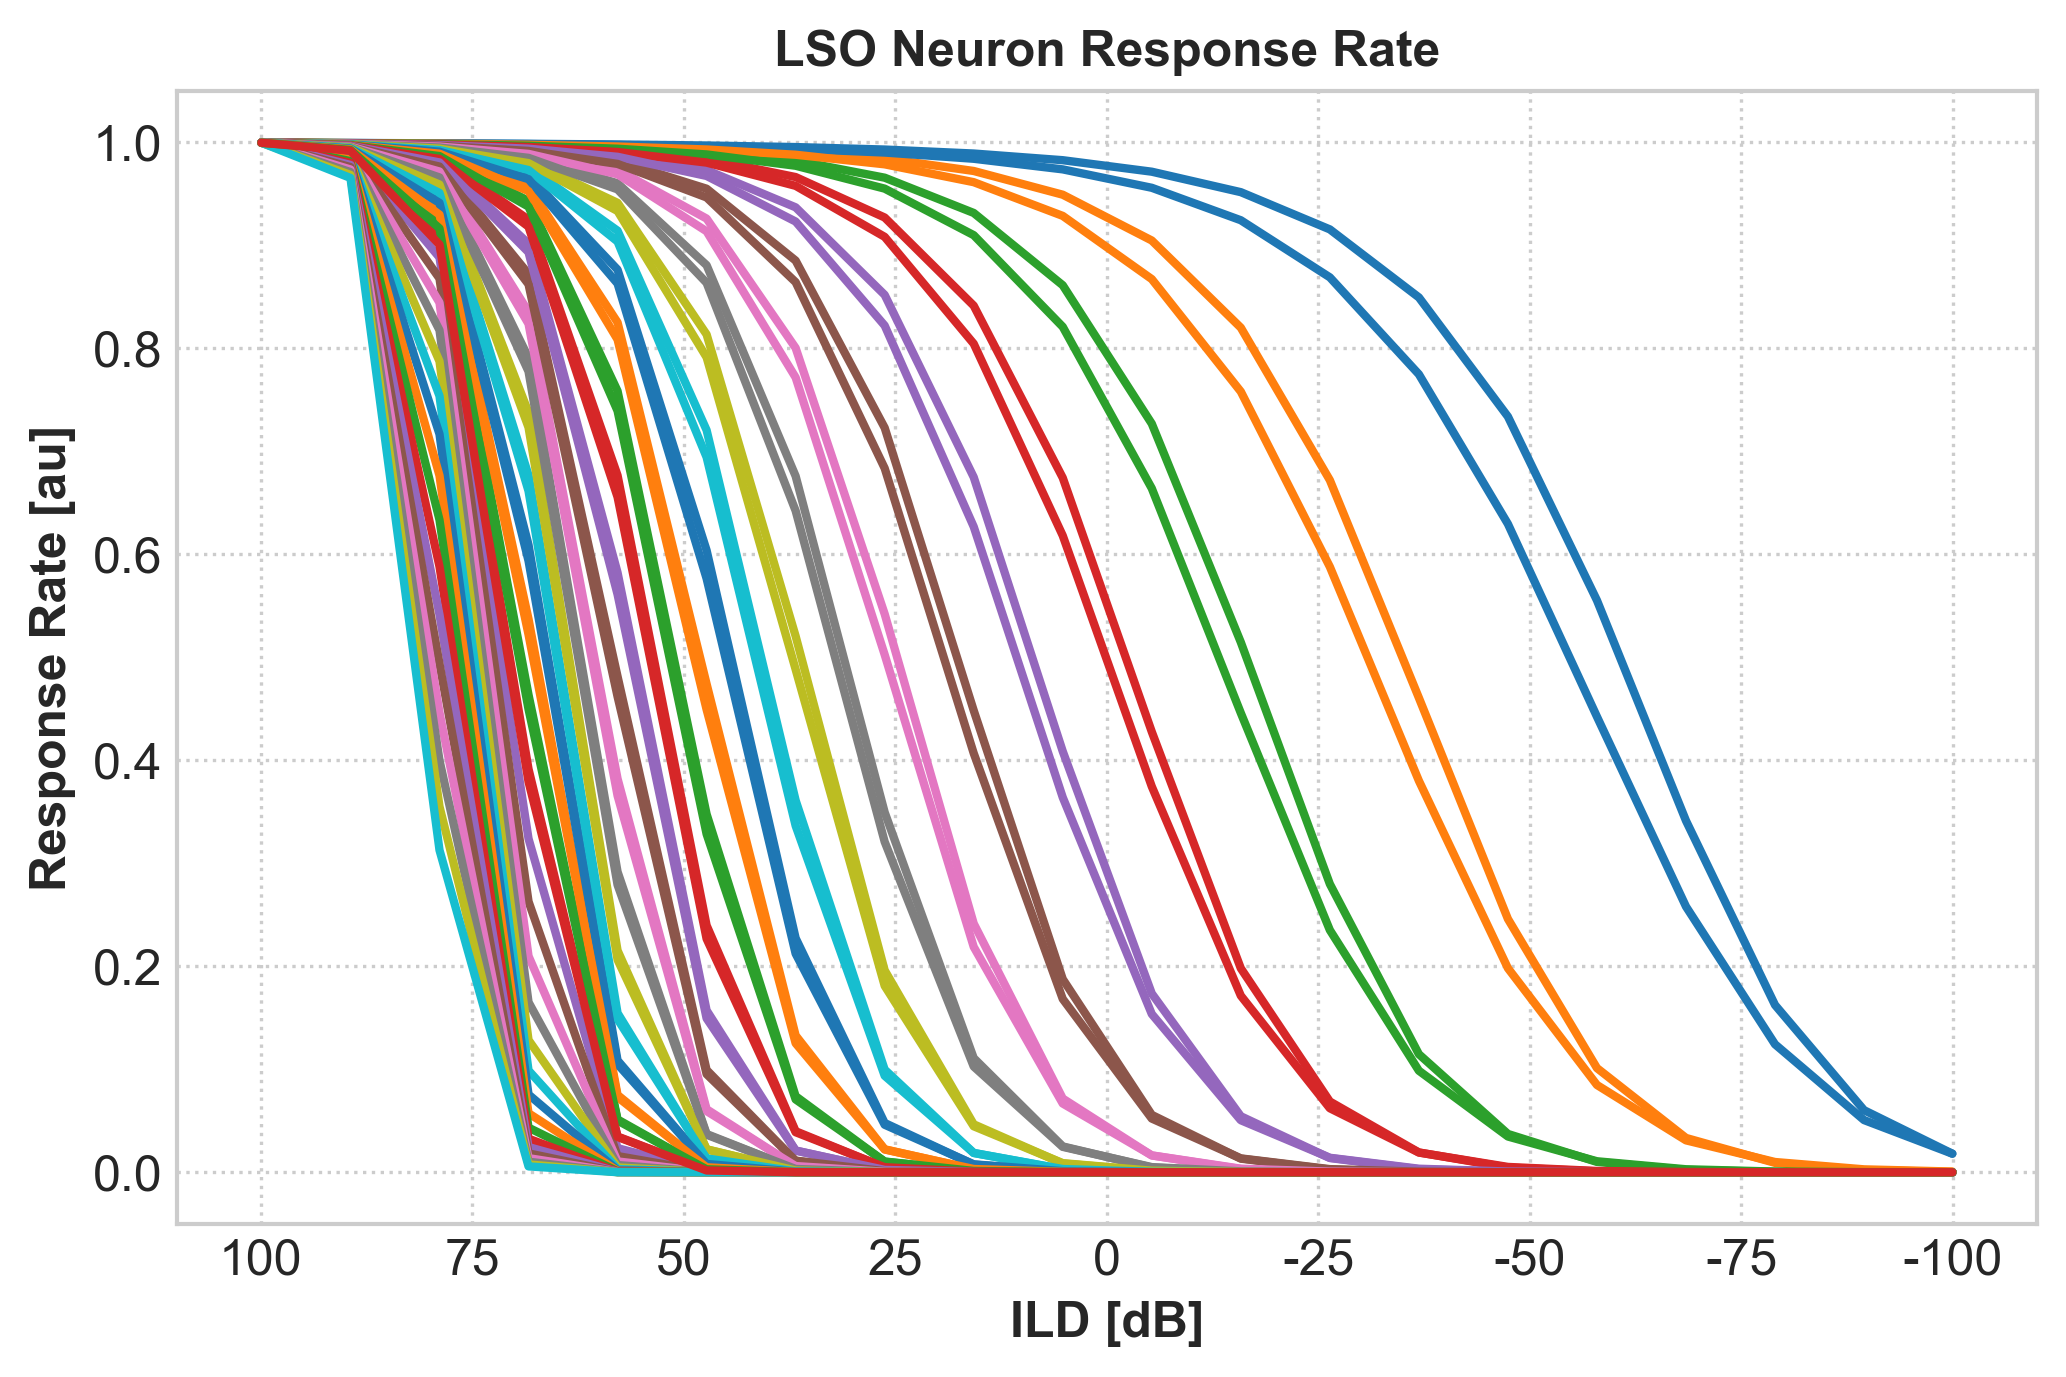

In [20]:
fig = plt.figure()
probing_times = np.arange(280,len(t),time_window)

ax1 = fig.add_subplot(111)
plt.title('LSO Neuron Response Rate')

k = 0
for i in range(0,len(kappas_r),5):
    
    for j in range(0,len(gammas_r),5):
        stri = r'$\gamma$ = {0:.1f}, $\kappa$ = {1:.1f}'.format(kappas_r[i],gammas_r[j])
        diff_input =  s_gbc_all-s_sbc_all
        diff_input = diff_input[:,sbc_center_frequencyBand]
        r = r_all[k,:,sbc_center_frequencyBand]
        plt.plot(-diff_input[probing_times],g_r_out(r[probing_times]),label=stri)
        k +=1
plt.xlabel('ILD [dB]')
plt.ylabel('Response Rate [au]')
ax1.invert_xaxis()
ax1.set_xticklabels([ int(round(k * 100)) for k in ax1.get_xticks()])

# lgd = plt.legend(loc=(1.04,0))


# plt.savefig(figure_name + 'response_all.svg', bbox_extra_artists=(lgd,), bbox_inches='tight')
# plt.savefig(figure_name + 'response_all.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

(40, 40, 20)
(40, 40)


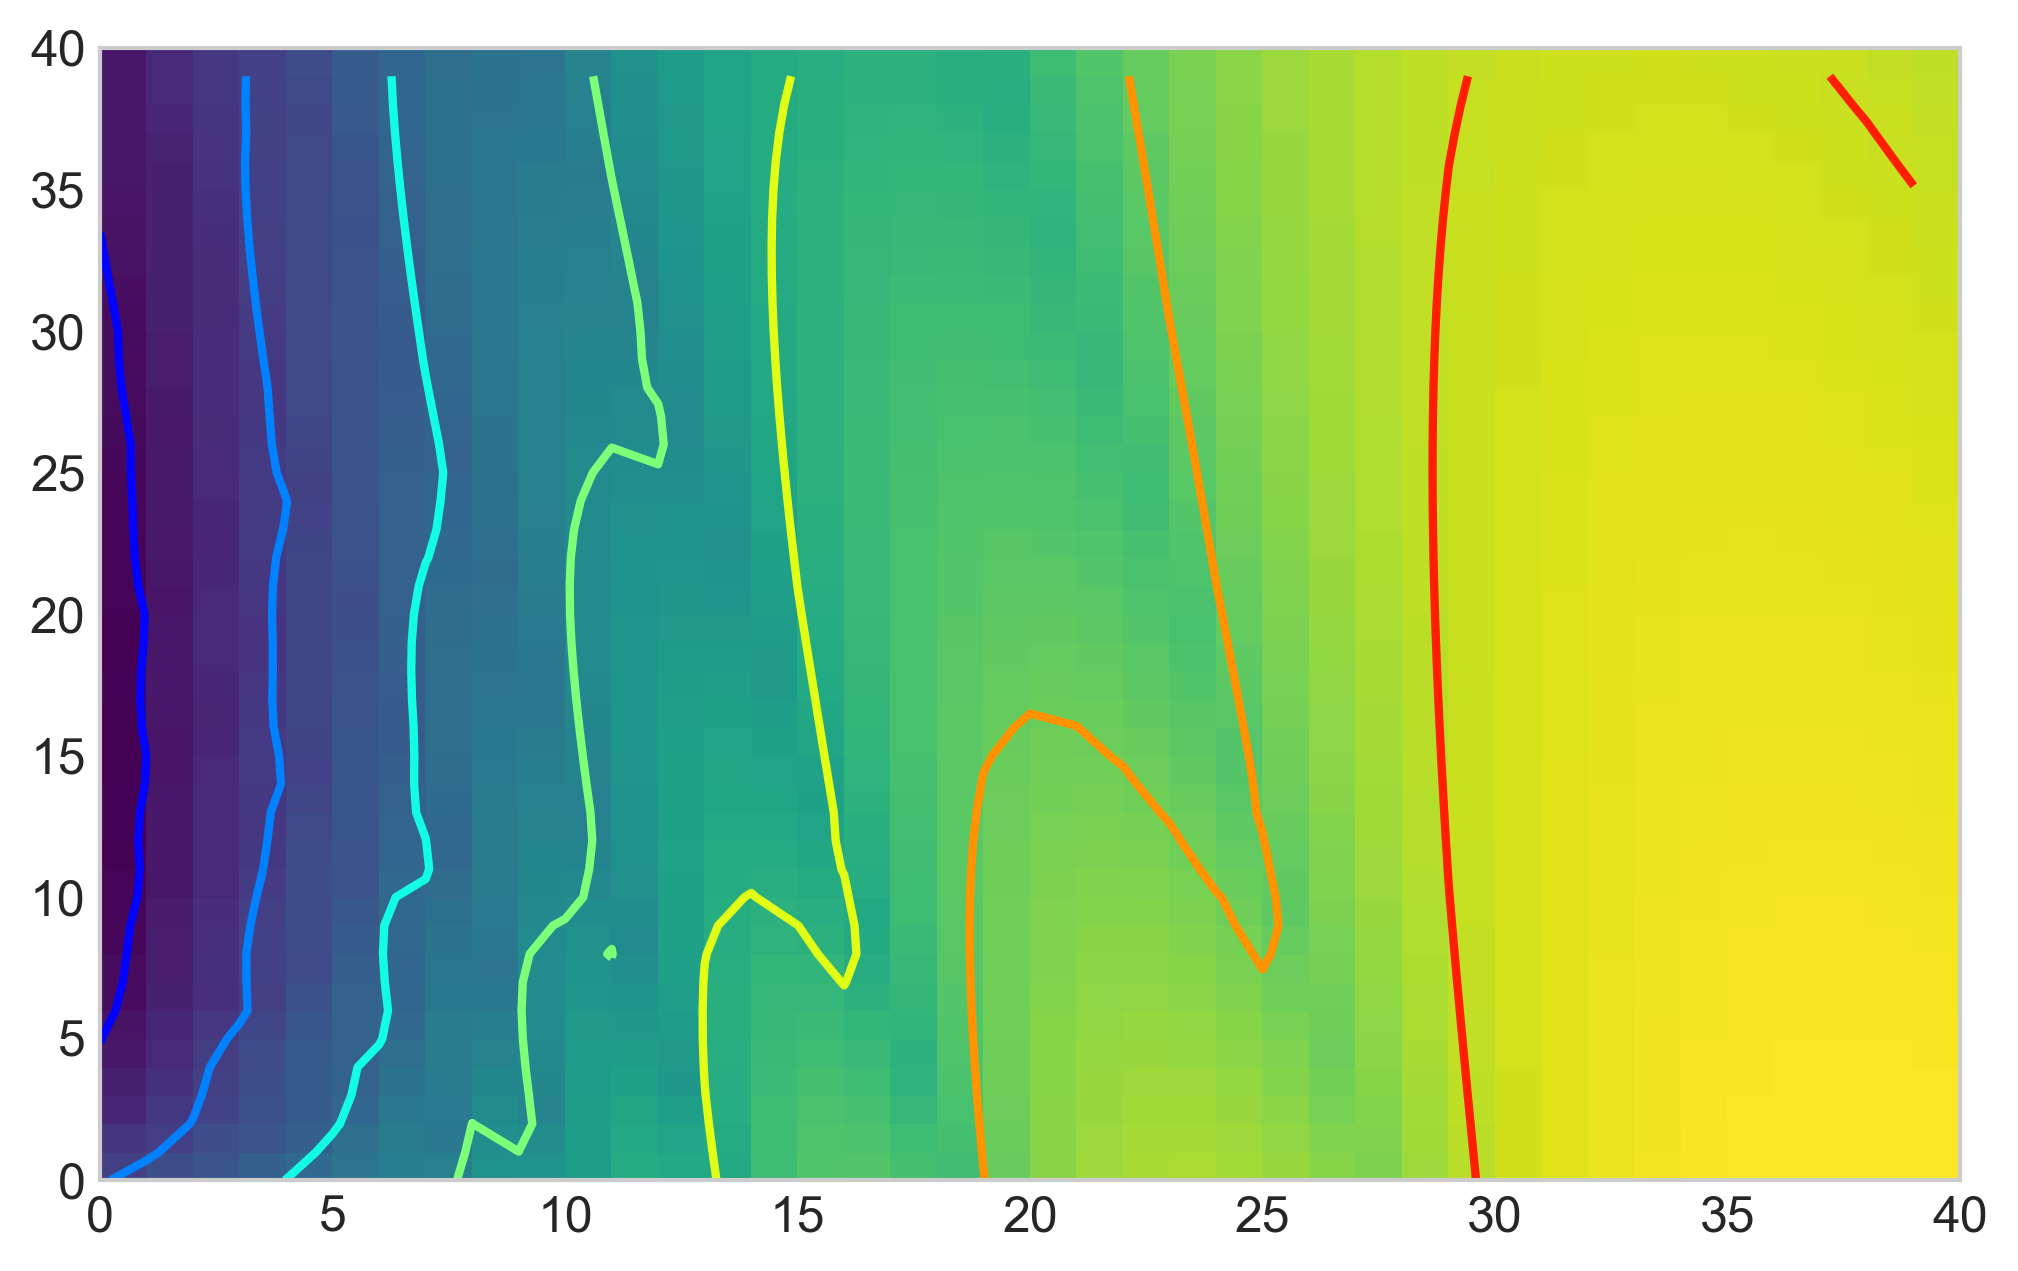

In [21]:
fig = plt.figure()
# ax2 = fig.add_subplot(111,projection='3d')
ax2 = fig.add_subplot(111)

## show LSO neuron response
# probing_times = np.arange(1900,len(t)-1900,time_window)
# probing_times = np.arange(2700,len(t)-1800,time_window)
# probing_times = 5000

r_all_reshaped = np.reshape(r_all,(kappas_r.shape[0],kappas_r.shape[0],r_all.shape[1],r_all.shape[2]))
print(g_r_out(r_all_reshaped[:,:,probing_times,2]).shape)

tmp = -np.array(np.gradient(g_r_out(r_all_reshaped[:,:,probing_times,2]),axis = 2))


# np.save('gaba_ratios',tmp)

# maxi_arg = np.squeeze(np.argmax(tmp,axis=2))
maxi = np.squeeze(np.max(tmp,axis=2))

# maxi = np.exp(maxi)

c = ax2.pcolormesh(maxi[:,:],cmap='viridis', zorder=-1)

print(maxi.shape)

ax2.contour(maxi,cmap='jet', zorder=2)
# data_peaks = np.zeros(maxi.shape[0])
# for i in range(maxi.shape[0]-26):
#     data_peaks[i] = np.argmax(maxi[:,i])
#     ax2.scatter(i,np.argmax(maxi[:,i]),s=120,linewidth=4,color= 'black',facecolors='none', zorder=1)
# #     print(np.argmax(maxi[:,i]))
# # calculate linear regression function for peak points (walk on the ridghe of the hill)
# fit = np.polyfit(range(data_peaks.shape[0]),data_peaks,1)
# fit_fn = np.poly1d(fit) 
# print(fit_fn)
# ax2.plot(fit_fn(range(maxi.shape[0])),color= 'black', linestyle = '--', zorder=1)
# ax2.annotate("Slope: {0:0.2f}".format(fit_fn[1]), xy=(maxi.shape[0]/2, 15), xytext=(maxi.shape[0]/2-7, 10))

# # ax2.hlines(30*0.38,0,30)

# cbar = plt.colorbar(c)
# cbar.set_label('Coding Precision [au]', rotation=270, labelpad=40,)

# # ax2.set_title('Coding Precision for Various GABA Value Ratios')
# ax2.set_xlabel(r'$\lambda_E$',fontsize=35)
# ax2.set_ylabel(r'$\lambda_I$',fontsize=35)


# # print(fit_fn[0]/41)
# # print(gaba_inh[8])

# # ax2.set_yticklabels(['{0:.2f}'.format(k) for k in np.linspace(0,1,len(ax2.get_yticks())-1)])
# # ax2.set_xticklabels(['{0:.2f}'.format(k/(maxi.shape[0]-1)) for k in ax2.get_xticks()])


# plt.tight_layout()

# plt.savefig(figure_name + 'plot.svg', bbox_inches='tight')
# plt.savefig(figure_name + 'plot.pdf', bbox_inches='tight')


plt.show()

(1600, 20)


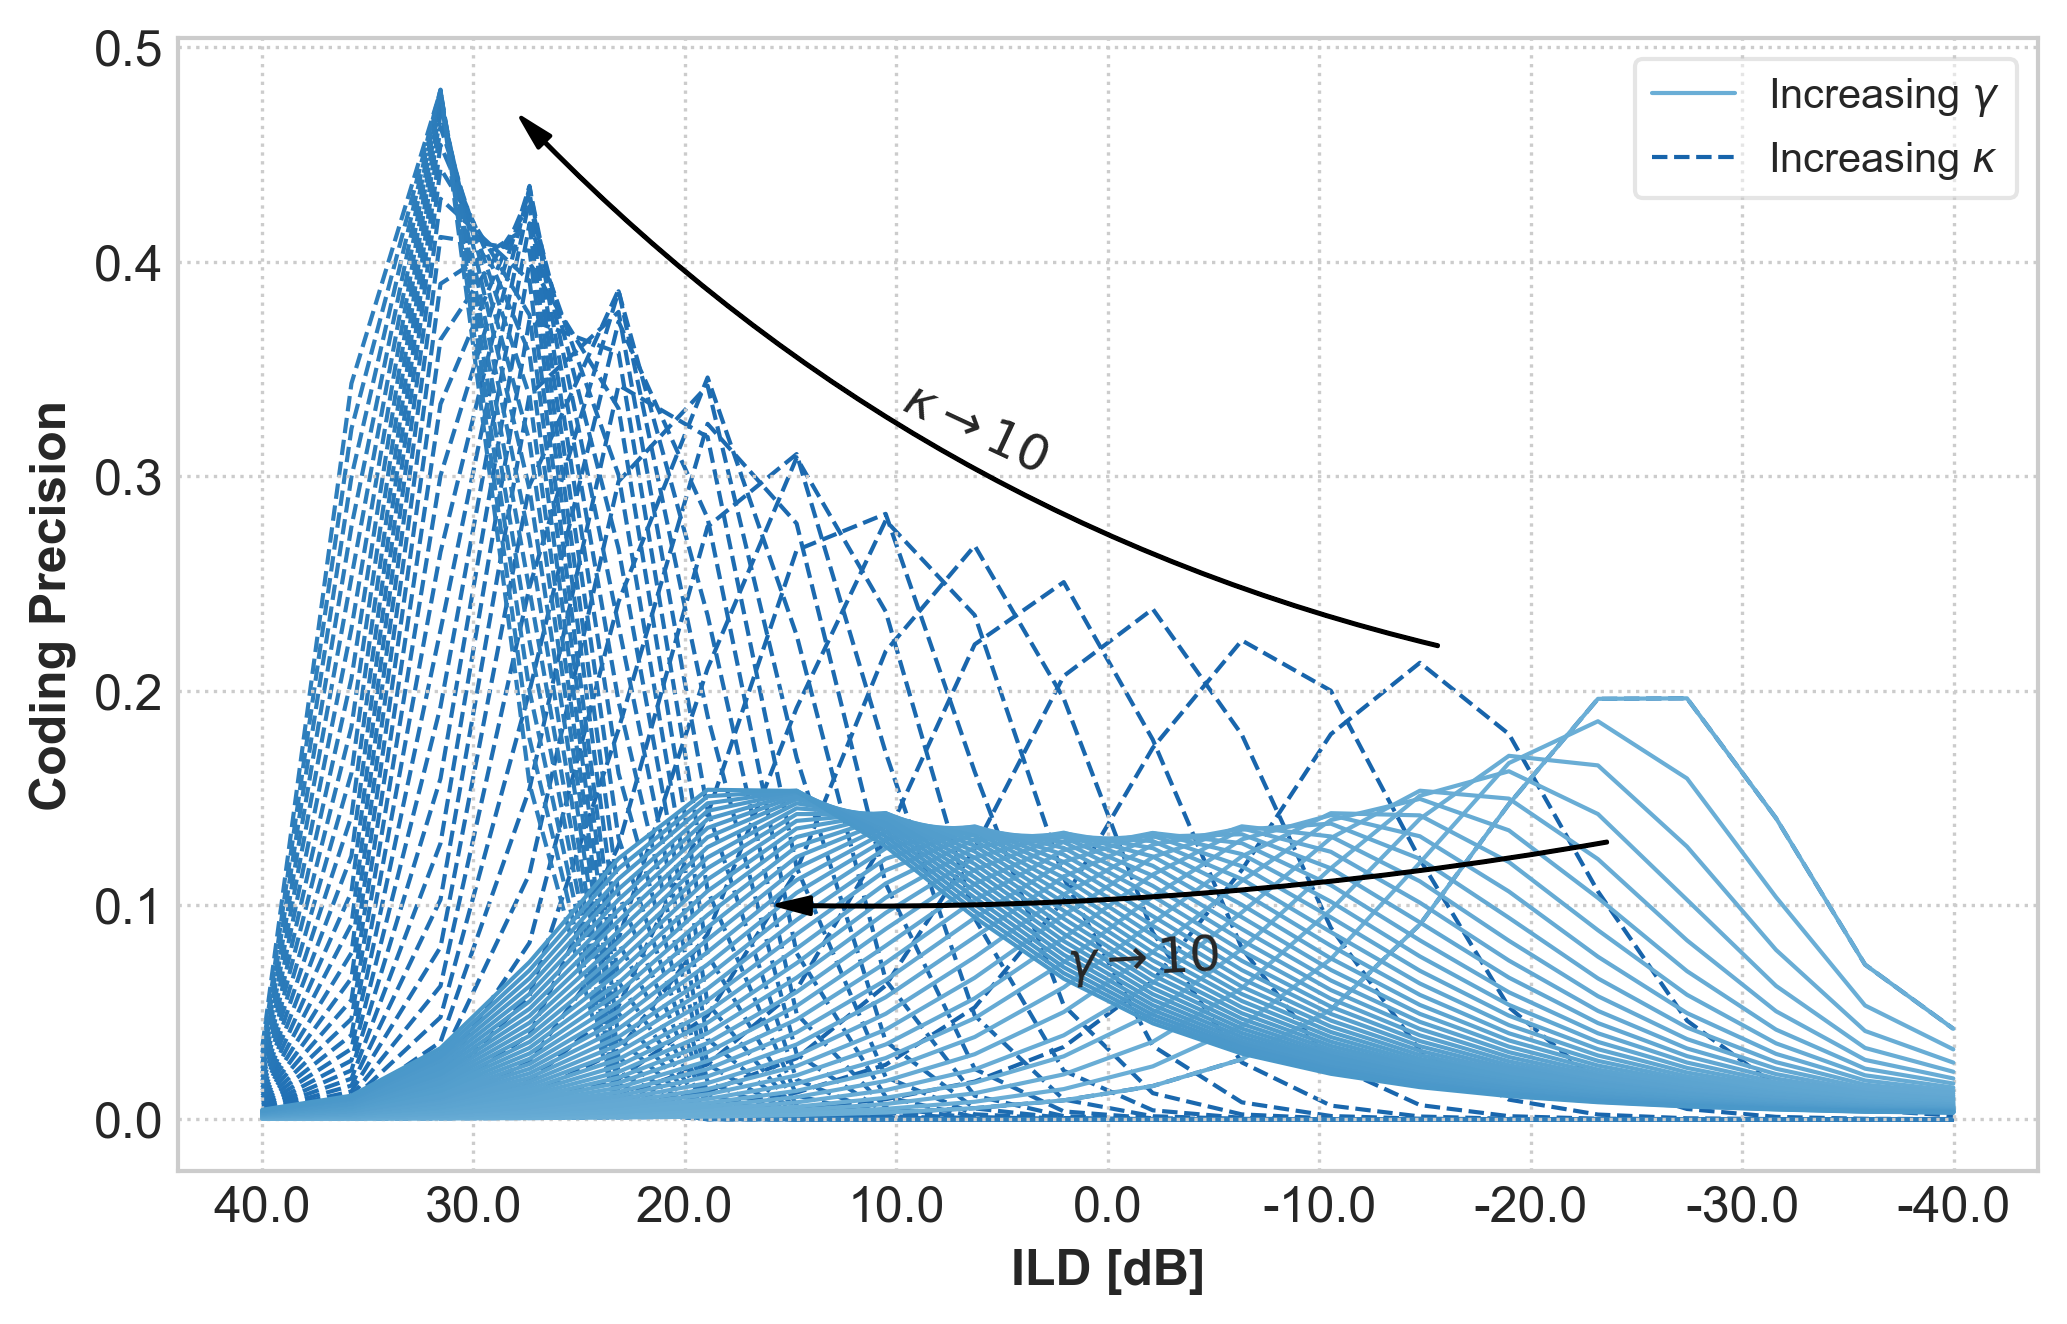

In [25]:
from mpltools import color
import matplotlib.patches as patches

# fig = plt.figure()
# ax2 = fig.add_subplot(111)

# probing_times = np.arange(300,len(t),time_window)
## show LSO neuron response
# ilds = np.zeros((len(probing_times),len(gaba_exc)))
# diff = diff_input[probing_times]
# for i in range(len(gaba_exc)):
#     j = i
#     tmp = g_r_out(r[i,j,probing_times])
#     # normalize it
# #     tmp = tmp -  np.min(tmp)
# #     tmp = tmp / np.max(tmp)
#     ilds[:,j] = tmp

                
# # ax2.plot(diff,ilds)
# # # plt.plot(ilds.T)
# # ax2.set_xticklabels([ round(k * 100) for k in ax2.get_xticks()])
# # ax2.invert_xaxis()

# # plt.title('Normalized Response')


fig = plt.figure()

## show LSO neuron response
ax2 = fig.add_subplot(111)

colors = plt.cm.Blues(np.linspace(0.5,0.6,kappas_r.shape[0]))
ax2.set_prop_cycle('color', colors)



r_all_reshaped = np.reshape(r_all,(kappas_r.shape[0],kappas_r.shape[0],r_all.shape[1],r_all.shape[2]))


diff_input =  s_gbc_all-s_sbc_all
diff_input = diff_input[:,sbc_center_frequencyBand]
diff = -diff_input[probing_times]



tmp =-np.array( np.gradient(g_r_out(r_all[:,probing_times,2]),axis=1))
print(tmp.shape)

a1 = ax2.plot(diff,tmp[0::40].T,linewidth = 1,linestyle='-',zorder=1,label=r"Increasing $\gamma$")

colors = plt.cm.Blues(np.linspace(0.8,0.7,kappas_r.shape[0]))
ax2.set_prop_cycle('color', colors)

a2 = ax2.plot(diff,tmp[0:40].T,linewidth = 1,linestyle='--',zorder=-2,label=r"Increasing $\kappa$")

max_inds = np.argmax(tmp,axis=1)
maxis = np.max(tmp,axis=1)

style="Simple,tail_width=0.2,head_width=4,head_length=8"
kw = dict(arrowstyle=style, color="k")
a3 = patches.FancyArrowPatch((-0.4,0.22), (0.7,0.47),connectionstyle="arc3,rad=-.15", **kw)
ax2.annotate(r"$\kappa \rightarrow 10$",size=12, xy=(0.1,0.35), xytext=(0.25,0.33),rotation=-25)
ax2.add_patch(a3)

a3 = patches.FancyArrowPatch( (-0.60,0.13),(0.4,0.1),connectionstyle="arc3,rad=-.05",zorder=5, **kw)
ax2.annotate(r"$\gamma \rightarrow 10$",size=12, xy=(0.1,0.35), xytext=(0.05,0.07),rotation=3)

ax2.add_patch(a3)

# tmp = g_r_out(r[0,0,probing_times])/norm_value
# # tmp = tmp -  np.min(tmp)
# # tmp = tmp / np.max(tmp)

# ax2.plot(diff,-np.gradient(tmp),linestyle='-',color='C0',label=r'$\lambda_e =$ {0:.2f}, $\lambda_i$ = {1:.2f}'.format(gaba_exc[0],gaba_inh[0]))




# calculate x value for first peak
# x1 = diff[np.argmax(-np.gradient(tmp))]
# x2 = diff[np.argmax(-np.gradient(tmp2))]
# ax2.annotate("", xy=(x2, 0.14), xytext=(x1, 0.14),arrowprops=dict(arrowstyle="|-|",linewidth=3))
# ax2.annotate("{0:2.0f}dB".format((x2-x1)*100), xy=((x2-x1)/2 -x2, 0.146), xytext=((x2-x1)/2 +x1+0.05, 0.146))


# y1 = np.max(-np.gradient(tmp))
# y2 = np.max(-np.gradient(tmp2))
# ax2.annotate("", xy=(0.18, y1), xytext=(0.18, y2),arrowprops=dict(arrowstyle="|-|",linewidth=3))
# ax2.annotate("{0:2.0f}%".format(100-(100/y1)*y2), xy=(0.14, y2+(y1-y2)/2), xytext=(0.14,  y2+(y1-y2)/2 -0.002))


l = [0]
l.extend(np.linspace(-40,40,len(ax1.get_xticklabels())-2))
ax2.set_xticklabels(l)
ax2.set_ylabel('Coding Precision')
ax2.set_xlabel('ILD [dB]')
ax2.invert_xaxis()
# ax2.set_ylim([0,0.17])
# # ax2.set_xlim([1,-1])
ax2.legend(handles=[a1[0],a2[0]])
# # plt.title('Coding Precision')

# plt.tight_layout()

plt.savefig(figure_name + 'coding_prescision.svg', bbox_inches='tight')
plt.savefig(figure_name + 'coding_prescision.pdf', bbox_inches='tight')
plt.savefig(figure_name + 'coding_prescision.tiff', bbox_inches='tight')

plt.show()



(1600, 20)
(1600,)


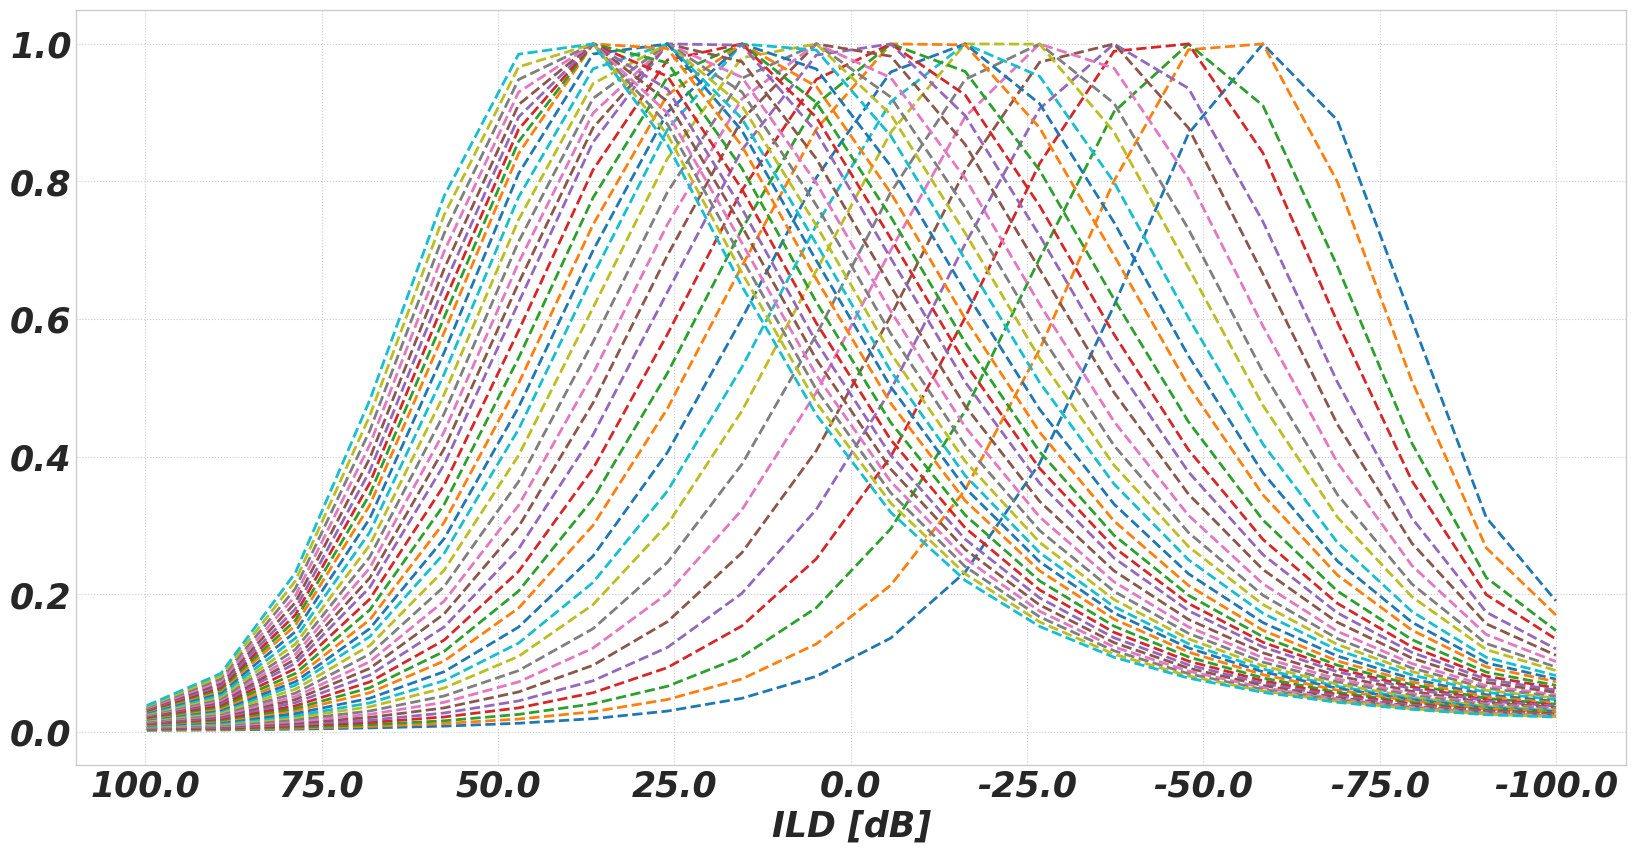

In [78]:
from mpltools import color

# fig = plt.figure()
# ax2 = fig.add_subplot(111)

# probing_times = np.arange(300,len(t),time_window)
## show LSO neuron response
# ilds = np.zeros((len(probing_times),len(gaba_exc)))
# diff = diff_input[probing_times]
# for i in range(len(gaba_exc)):
#     j = i
#     tmp = g_r_out(r[i,j,probing_times])
#     # normalize it
# #     tmp = tmp -  np.min(tmp)
# #     tmp = tmp / np.max(tmp)
#     ilds[:,j] = tmp

                
# # ax2.plot(diff,ilds)
# # # plt.plot(ilds.T)
# # ax2.set_xticklabels([ round(k * 100) for k in ax2.get_xticks()])
# # ax2.invert_xaxis()

# # plt.title('Normalized Response')


fig = plt.figure()

## show LSO neuron response
ax2 = fig.add_subplot(111)
# colors = plt.cm.Blues(np.linspace(0.4,0.7,ilds.shape[1]))
# ax2.set_prop_cycle('color', colors)

# #normalize it
# norm_value = np.max(ilds.flatten())
# ilds /= norm_value

#######
# DIFF
#######


r_all_reshaped = np.reshape(r_all,(kappas_r.shape[0],kappas_r.shape[0],r_all.shape[1],r_all.shape[2]))


diff_input =  s_gbc_all-s_sbc_all
diff_input = diff_input[:,sbc_center_frequencyBand]
diff = -diff_input[probing_times]
# tmp = -np.array(np.gradient(g_r_out(r_all_reshaped[:,:,probing_times,2]),axis = 2))

###########
# GRADIENT
###########

# tmp2 = g_r_out(r[-4,-4,probing_times])/norm_value
# # tmp2 = tmp2 -  np.min(tmp2)
# # tmp2 = tmp2 / np.max(tmp2)
# ax2.plot(diff,-np.gradient(tmp2),linestyle='-',color='#6baed6',label=r'$\lambda_e =$ {0:.2f}, $\lambda_i$ = {1:.2f}'.format(gaba_exc[-4],gaba_inh[-4]))


tmp =-np.array( np.gradient(g_r_out(r_all[:,probing_times,2]),axis=1))
print(tmp.shape)

# ax2.plot(diff,tmp[0:40].T,linewidth = int(drawing_size/9),linestyle='--')

tmp =  (tmp.T / np.max(tmp,axis=1)).T

ax2.plot(diff,tmp[0::40].T,linewidth = int(drawing_size/9),linestyle='--')

max_inds = np.argmax(tmp,axis=1)
maxis = np.max(tmp,axis=1)

print(max_inds.shape)

# tmp = g_r_out(r[0,0,probing_times])/norm_value
# # tmp = tmp -  np.min(tmp)
# # tmp = tmp / np.max(tmp)

# ax2.plot(diff,-np.gradient(tmp),linestyle='-',color='C0',label=r'$\lambda_e =$ {0:.2f}, $\lambda_i$ = {1:.2f}'.format(gaba_exc[0],gaba_inh[0]))




# calculate x value for first peak
# x1 = diff[np.argmax(-np.gradient(tmp))]
# x2 = diff[np.argmax(-np.gradient(tmp2))]
# ax2.annotate("", xy=(x2, 0.14), xytext=(x1, 0.14),arrowprops=dict(arrowstyle="|-|",linewidth=3))
# ax2.annotate("{0:2.0f}dB".format((x2-x1)*100), xy=((x2-x1)/2 -x2, 0.146), xytext=((x2-x1)/2 +x1+0.05, 0.146))


# y1 = np.max(-np.gradient(tmp))
# y2 = np.max(-np.gradient(tmp2))
# ax2.annotate("", xy=(0.18, y1), xytext=(0.18, y2),arrowprops=dict(arrowstyle="|-|",linewidth=3))
# ax2.annotate("{0:2.0f}%".format(100-(100/y1)*y2), xy=(0.14, y2+(y1-y2)/2), xytext=(0.14,  y2+(y1-y2)/2 -0.002))


ax2.set_xticklabels([ round(k * 100) for k in ax2.get_xticks()])
# ax2.set_ylabel('Coding Precision')
ax2.set_xlabel('ILD [dB]')
ax2.invert_xaxis()
# ax2.set_ylim([0,0.17])
# # ax2.set_xlim([1,-1])
# ax2.legend()
# # plt.title('Coding Precision')

# plt.tight_layout()

# plt.savefig(figure_name + 'coding_prescision.svg', bbox_inches='tight')
# plt.savefig(figure_name + 'coding_prescision.pdf', bbox_inches='tight')

plt.show()

